# Домашнее задание №6 по теме "Двухуровневые модели рекомендаций".

In [1]:
# данные расширения позволяют подтягивать изменения библиотеки сразу (не надо ядро перезагружать)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from best_rec_lib.metrics import precision_at_k, recall_at_k
from best_rec_lib.utils import prefilter_items
from best_rec_lib.recommenders import MainRecommender

## Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


### Загрузка и разделение данных

In [3]:
data = pd.read_csv('../../data/retail_train.csv')
item_features = pd.read_csv('../../data/product.csv')
user_features = pd.read_csv('../../data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


### Отбор топ-5000 товаров

In [4]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


### Обучение модели и создание результирующего датасета

In [5]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [6]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


### Получение рекомендаций

In [7]:
result_lvl_1['ALS_20'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=20))
result_lvl_1['ALS_50'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))
result_lvl_1['ALS_100'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=100))
result_lvl_1['ALS_200'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=200))
result_lvl_1['ALS_500'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=500))

In [8]:
result_lvl_1['OWN_20'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=20))
result_lvl_1['OWN_50'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
result_lvl_1['OWN_100'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=100))
result_lvl_1['OWN_200'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))
result_lvl_1['OWN_500'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=500))

In [9]:
result_lvl_1.head(1)

,user_id,actual,ALS_20,ALS_50,ALS_100,ALS_200,ALS_500,OWN_20,OWN_50,OWN_100,OWN_200,OWN_500
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1082185, 995242, 981760, 1005186, 885290, 653...","[1082185, 995242, 981760, 1005186, 885290, 653...","[1082185, 995242, 981760, 1005186, 885290, 653...","[1082185, 995242, 981760, 1005186, 885290, 653...","[1082185, 995242, 981760, 1005186, 885290, 653...","[1082185, 6534178, 1029743, 995242, 1106523, 9...","[1082185, 6534178, 1029743, 995242, 1106523, 9...","[1082185, 6534178, 1029743, 995242, 1106523, 9...","[1082185, 6534178, 1029743, 995242, 1106523, 9...","[1082185, 6534178, 1029743, 995242, 1106523, 9..."


### Оценка

In [10]:
rez_ALS=[]
rez_ALS.append(result_lvl_1.apply(lambda row: recall_at_k(row['ALS_20'], row['actual'], k=20), axis=1).mean())
rez_ALS.append(result_lvl_1.apply(lambda row: recall_at_k(row['ALS_50'], row['actual'], k=50), axis=1).mean())
rez_ALS.append(result_lvl_1.apply(lambda row: recall_at_k(row['ALS_100'], row['actual'], k=100), axis=1).mean())
rez_ALS.append(result_lvl_1.apply(lambda row: recall_at_k(row['ALS_200'], row['actual'], k=200), axis=1).mean())
rez_ALS.append(result_lvl_1.apply(lambda row: recall_at_k(row['ALS_500'], row['actual'], k=500), axis=1).mean())

In [11]:
rez_OWN=[]
rez_OWN.append(result_lvl_1.apply(lambda row: recall_at_k(row['OWN_20'], row['actual'], k=20), axis=1).mean())
rez_OWN.append(result_lvl_1.apply(lambda row: recall_at_k(row['OWN_50'], row['actual'], k=50), axis=1).mean())
rez_OWN.append(result_lvl_1.apply(lambda row: recall_at_k(row['OWN_100'], row['actual'], k=100), axis=1).mean())
rez_OWN.append(result_lvl_1.apply(lambda row: recall_at_k(row['OWN_200'], row['actual'], k=200), axis=1).mean())
rez_OWN.append(result_lvl_1.apply(lambda row: recall_at_k(row['OWN_500'], row['actual'], k=500), axis=1).mean())

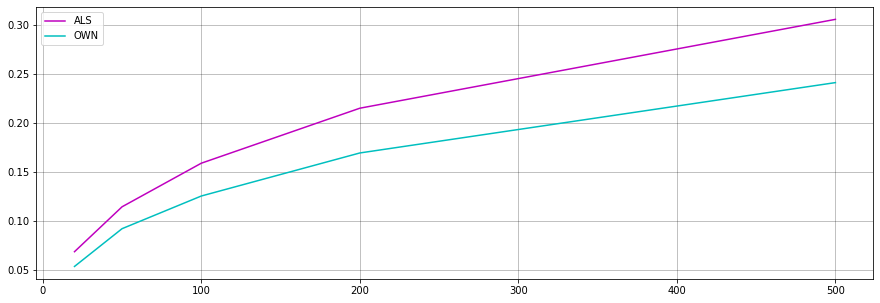

In [12]:
plt.figure(figsize=(15, 5))
plt.plot([20,50,100,200,500], rez_ALS, c = "m", label='ALS')
plt.plot([20,50,100,200,500], rez_OWN, c = "c", label='OWN')
plt.grid(which='major',color='black',alpha=0.3)
plt.legend()
plt.show()

**Вывод:** Как видно из графика, own recommendtions + top-popular не дают лучший recall по сравнению с ALS. Начиная с K=200 зависимость recall от K становится четко линейной. Исходя из этого, наиболее разумным значением K является от 0 до 200.

---

## Задание 2.

Обучите модель 2-ого уровня, при этом:

    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

### Подготовка датасета второго уровня

In [13]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [14]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[1082185, 6534178, 1029743, 995242, 1106523, 9..."
1,2021,"[1082185, 6534178, 1029743, 995242, 1106523, 9..."


In [15]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(4)

,user_id,item_id,flag
0,2070,1082185,1
0,2070,6534178,1
0,2070,1029743,1
0,2070,995242,1


In [16]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [17]:
targets_lvl_2.head(2)

,user_id,item_id,target
0,2070,1082185,1.0
1,2070,6534178,1.0


### Присоединение фичей к основному датасету

In [18]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [19]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [20]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1082185,1.0,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,6534178,1.0,69,KIOSK-GAS,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


### Разбивка датасета второго уровня и построение модели:

In [21]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [22]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [23]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

C:\Users\rfk03\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rfk03\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rfk03\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


### Оценка

In [24]:
preds = pd.DataFrame({'preds': train_preds})
join = y_train.join(preds, rsuffix='_right') 

In [25]:
join.head()

,target,preds
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,0.0,0.0
4,1.0,0.0


In [26]:
from sklearn.metrics import precision_score

In [27]:
precision_score(join['target'], join['preds'], average='macro')

0.8114611174296966

In [28]:
result_lvl_1.apply(lambda row: precision_at_k(row['ALS_50'], row['actual'], k=1), axis=1).mean()

0.27390900649953576

**Вывод:** Precision двухуровневой модели намного выше чем у одноуровневой.

---